In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None


def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
        
        
def maybe_download(filename, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    else:
        print(filename, 'is already downloaded. Skipped.')
    return filename

In [3]:
train_filename = maybe_download('train.tar.gz')

train.tar.gz is already downloaded. Skipped.


In [4]:
test_filename = maybe_download('test.tar.gz')

test.tar.gz is already downloaded. Skipped.


In [5]:
extra_filename = maybe_download('extra.tar.gz')

extra.tar.gz is already downloaded. Skipped.


In [6]:
np.random.seed(133)


def maybe_extract(file_, force=False):
    filename = os.path.splitext(os.path.splitext(file_)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(filename) and not force:
        # You may override by setting force=True.
        print('%s is already presented - Skipping extraction of %s.' % (filename, file_))
    else:
        print('Extracting %s file data. Please wait...' % file_)
        tar = tarfile.open(file_)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        print('File %s is successfully extracted into %s directory.' % (file_, filename))        
    
    return filename

In [7]:
# Variables contain directory names where data is extracted
train_folder = maybe_extract(train_filename)

Extracting train.tar.gz file data. Please wait...
File train.tar.gz is successfully extracted into train directory.


In [8]:
test_folder = maybe_extract(test_filename)

Extracting test.tar.gz file data. Please wait...
File test.tar.gz is successfully extracted into test directory.


In [9]:
extra_folder = maybe_extract(extra_filename)

Extracting extra.tar.gz file data. Please wait...
File extra.tar.gz is successfully extracted into extra directory.


In [10]:
def remove_anomaly_samples(data, max_class_length = 5):
    """
    Here we remove all data which has class length higher than specified value.
    """
    print("\nDataset size before update:", len(data))
    
    for i in range(len(data)):
        if i < len(data) and len(data[i]['label']) > max_class_length:
            print("\nAnomaly at index %d detected. Class size: %d" % (i, len(data[i]['label'])))
            del data[i]
            
    print("\nDataset after before update:", len(data))            
    return data

In [11]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#     file_:            The input h5 matlab file
#     digitStructName   The h5 ref to all the file names
#     digitStructBbox   The h5 ref to all struc data
class DigitStructsWrapper:
    def __init__(self, file_, start_ = 0, end_ = 0):
        self.file_ = h5py.File(file_, 'r')
        self.names = self.file_['digitStruct']['name'][start_:end_] if end_ > 0 else self.file_['digitStruct']['name']
        self.bboxes = self.file_['digitStruct']['bbox'][start_:end_] if end_ > 0 else self.file_['digitStruct']['bbox']
        self.collectionSize = len(self.names)
        print("\n%s file structure contain %d entries" % (file_, self.collectionSize))
        
        
    def bboxHelper(self, keys_):
        """
        Method handles the coding difference when there is exactly one bbox or an array of bbox. 
        """
        if (len(keys_) > 1):
            val = [self.file_[keys_.value[j].item()].value[0][0] for j in range(len(keys_))]
        else:
            val = [keys_.value[0][0]]
        return val

    
    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self, n):
        bbox = {}
        bb = self.bboxes[n].item()
        bbox['height'] = self.bboxHelper(self.file_[bb]["height"])
        bbox['left'] = self.bboxHelper(self.file_[bb]["left"])
        bbox['top'] = self.bboxHelper(self.file_[bb]["top"])
        bbox['width'] = self.bboxHelper(self.file_[bb]["width"])
        bbox['label'] = self.bboxHelper(self.file_[bb]["label"])
        return bbox

    
    def getName(self, n):
        """
        Method returns the filename for the n(th) digitStruct. Since each letter is stored in a structure 
        as array of ANSII char numbers we should convert it back by calling chr function.
        """
        return ''.join([chr(c[0]) for c in self.file_[self.names[n][0]].value])

    
    def getNumberStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllNumbersStructure(self):
        """
        Method returns an array, which contains information about every image.
        This info contains: positions, labels 
        """
        return [self.getNumberStructure(i) for i in range(self.collectionSize)]

    
    # Return a restructured version of the dataset (one object per digit in 'boxes').
    #
    #   Return a list of dicts :
    #      'filename' : filename of the samples
    #      'boxes' : list of dicts (one by digit) :
    #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
    #          'left', 'top' : position of bounding box
    #          'width', 'height' : dimension of bounding box
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllNumbersRestructured(self): # getAllDigitStructure_ByDigit
        numbersData = self.getAllNumbersStructure()
        print("\nObject structure before transforming: ", numbersData[0])
        remove_anomaly_samples(numbersData)
        
        result = []
        for numData in numbersData:
            metadatas = []
            for i in range(len(numData['height'])):
                metadata = {}
                metadata['height'] = numData['height'][i]
                metadata['label']  = numData['label'][i]
                metadata['left']   = numData['left'][i]
                metadata['top']    = numData['top'][i]
                metadata['width']  = numData['width'][i]
                metadatas.append(metadata)
                
            result.append({ 'boxes':metadatas, 'name':numData["name"] })
            
        print("\nObject structure after transforming: ", result[0])
        
        return result

In [12]:
file_ = os.path.join(train_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
train_data = dsf.getAllNumbersRestructured()


train/digitStruct.mat file structure contain 33402 entries

Object structure before transforming:  {'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}

Dataset size before update: 33402

Anomaly at index 29929 detected. Class size: 6

Dataset after before update: 33401

Object structure after transforming:  {'boxes': [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}], 'name': '1.png'}


In [13]:
file_ = os.path.join(test_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
test_data = dsf.getAllNumbersRestructured()


test/digitStruct.mat file structure contain 13068 entries

Object structure before transforming:  {'name': '1.png', 'top': [7.0], 'label': [5.0], 'width': [19.0], 'height': [30.0], 'left': [43.0]}

Dataset size before update: 13068

Dataset after before update: 13068

Object structure after transforming:  {'boxes': [{'width': 19.0, 'top': 7.0, 'label': 5.0, 'left': 43.0, 'height': 30.0}], 'name': '1.png'}


In [14]:
file_ = os.path.join(extra_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_, 0, 50000)
extra_data = dsf.getAllNumbersRestructured()


extra/digitStruct.mat file structure contain 50000 entries

Object structure before transforming:  {'name': '1.png', 'top': [70.0, 41.0, 23.0], 'label': [4.0, 7.0, 8.0], 'width': [38.0, 36.0, 47.0], 'height': [56.0, 56.0, 56.0], 'left': [24.0, 55.0, 79.0]}

Dataset size before update: 50000

Dataset after before update: 50000

Object structure after transforming:  {'boxes': [{'width': 38.0, 'top': 70.0, 'label': 4.0, 'left': 24.0, 'height': 56.0}, {'width': 36.0, 'top': 41.0, 'label': 7.0, 'left': 55.0, 'height': 56.0}, {'width': 47.0, 'top': 23.0, 'label': 8.0, 'left': 79.0, 'height': 56.0}], 'name': '1.png'}


In [15]:
from PIL import Image

def print_data_stats(data, folder):
    data_imgSize = np.ndarray([len(data),2])

    for i in np.arange(len(data)):
        filename = data[i]['name']
        filepath = os.path.join(folder, filename)
        data_imgSize[i, :] = Image.open(filepath).size[:]

    max_w, max_h = np.amax(data_imgSize[:,0]), np.amax(data_imgSize[:,1])
    min_w, min_h = np.amin(data_imgSize[:,0]), np.amin(data_imgSize[:,1])
    mean_w, mean_h = np.mean(data_imgSize[:,0]), np.mean(data_imgSize[:,1])
    print(folder, "max width and height:", max_w, max_h) 
    print(folder, "min width and height:", min_w, min_h)
    print(folder, "mean width and height:", mean_w, mean_h, "\n")
    
    max_w_i, max_h_i = np.where(data_imgSize[:,0] == max_w), np.where(data_imgSize[:,1] == max_h)
    print(folder, "max width indicies:", max_w_i) 
    print(folder, "max height indicies:", max_h_i, "\n")
    
    
    min_w_i, min_h_i = np.where(data_imgSize[:,0] == min_w), np.where(data_imgSize[:,1] == min_h)
    print(folder, "min width indicies:", min_w_i) 
    print(folder, "min height indicies:", min_h_i, "\n***\n")

In [16]:
print_data_stats(train_data, train_folder)
print_data_stats(test_data, test_folder)
print_data_stats(extra_data, extra_folder)

train max width and height: 876.0 501.0
train min width and height: 25.0 12.0
train mean width and height: 128.286338732 57.2139456902 

train max width indicies: (array([  410,  4163, 15855, 30483]),)
train max height indicies: (array([15855]),) 

train min width indicies: (array([9747]),)
train min height indicies: (array([ 1813,  2291,  4829,  5691,  9488,  9747,  9831, 10175, 10938,
       14902, 16284, 20314, 20775, 21544, 22330, 24015, 25438, 26047,
       26345, 27062, 27160, 27593, 27959, 29526, 29701, 30064, 30089,
       30462, 30947, 32339, 32351, 32539, 32567, 33141, 33180, 33202]),) 
***

test max width and height: 1083.0 516.0
test min width and height: 31.0 13.0
test mean width and height: 172.583486379 71.5664983165 

test max width indicies: (array([ 1722,  2949,  6233, 12862]),)
test max height indicies: (array([14]),) 

test min width indicies: (array([  459,  5352,  7776, 11257, 12191]),)
test min height indicies: (array([ 145, 1591, 5352, 7776]),) 
***

extra max w

In [17]:
img_size = 32

def prepare_images(samples, folder):
    print("Started preparing images for convnet...")
    
    prepared_images = np.ndarray([len(samples),img_size,img_size,1], dtype='float32')
    actual_numbers = np.ones([len(samples),6], dtype=int) * 10
    files = []
    for i in range(len(samples)):
        filename = samples[i]['name']
        filepath = os.path.join(folder, filename)
        image = Image.open(filepath)
        boxes = samples[i]['boxes']
        number_length = len(boxes)
        files.append(filename)
        
        # at 0 index we store length of a label. 3 -> 1; 123-> 3, 12543 -> 5
        actual_numbers[i,0] = number_length
        
        top = np.ndarray([number_length], dtype='float32')
        left = np.ndarray([number_length], dtype='float32')
        height = np.ndarray([number_length], dtype='float32')
        width = np.ndarray([number_length], dtype='float32')
        
        for j in range(number_length):
            # here we use j+1 since first entry used by label length
            actual_numbers[i,j+1] = boxes[j]['label']
            if boxes[j]['label'] == 10: # Replacing 10 with 0
                actual_numbers[i,j+1] = 0
                
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        img_min_top = np.amin(top)
        img_min_left = np.amin(left)
        img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
        img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

        img_left = np.floor(img_min_left - 0.1 * img_width)
        img_top = np.floor(img_min_top - 0.1 * img_height)
        img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
        img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]])
            
        image = image.crop((img_left, img_top, img_right, img_bottom)).resize([img_size, img_size], Image.ANTIALIAS) # Resize image to 32x32
        image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) # Convert image to the grayscale

        mean = np.mean(image, dtype='float32')
        std = np.std(image, dtype='float32', ddof=1)
        if std < 0.0001: 
            std = 1.0
        image = (image - mean) / std
        prepared_images[i,:,:] = image[:,:,:]
        
    print("Completed. Images cropped, resized and grayscaled")
    
    return prepared_images, actual_numbers, files

In [18]:
train_data, train_labels, _ = prepare_images(train_data, train_folder)
print(train_data.shape, train_labels.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(33401, 32, 32, 1) (33401, 6)


In [19]:
test_data, test_labels, test_filenames = prepare_images(test_data, test_folder)
print(test_data.shape, test_labels.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(13068, 32, 32, 1) (13068, 6)


In [20]:
extra_data, extra_labels, _ = prepare_images(extra_data, extra_folder)
print(extra_data.shape, extra_data.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(50000, 32, 32, 1) (50000, 32, 32, 1)


In [21]:
print(extra_labels[:10])

[[ 3  4  7  8 10 10]
 [ 2  7  1 10 10 10]
 [ 3  1  7  4 10 10]
 [ 2  3  0 10 10 10]
 [ 3  2  8  8 10 10]
 [ 2  3  1 10 10 10]
 [ 3  1  7  0 10 10]
 [ 2  8  1 10 10 10]
 [ 2  5  6 10 10 10]
 [ 3  4  4  4 10 10]]


In [22]:
from sklearn.utils import shuffle

# Here we add new data to our training set from extra set.
# Then we remove this part from memory to free it
train_data_temp = np.concatenate((train_data, extra_data[:40000, :, :, :]))
extra_data_temp = np.delete(extra_data, np.arange(40000), axis=0)

train_labels_temp = np.concatenate((train_labels, extra_labels[:40000]))
extra_labels_temp = np.delete(extra_labels, np.arange(40000), axis=0)

# And then we shuffle all the data we have
train_data_temp, train_labels_temp = shuffle(train_data_temp, train_labels_temp)
extra_data_temp, extra_labels_temp = shuffle(extra_data_temp, extra_labels_temp)
test_data_temp, test_labels_temp, test_filenames_temp = shuffle(test_data, test_labels, test_filenames)

print("\nTrain shapes:", train_data_temp.shape, train_labels_temp.shape)
print("Extra shapes:", extra_data_temp.shape, extra_labels_temp.shape)
print("Test shapes:", test_data_temp.shape, test_labels_temp.shape)


Train shapes: (73401, 32, 32, 1) (73401, 6)
Extra shapes: (10000, 32, 32, 1) (10000, 6)
Test shapes: (13068, 32, 32, 1) (13068, 6)


In [23]:
pickle_file = 'SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data_temp,
        'train_labels': train_labels_temp,
        'test_data': test_data_temp,
        'test_labels': test_labels_temp,
        'test_filenames': test_filenames_temp,
        'valid_data': extra_data_temp, # The rest of extra data will be used 
        'valid_labels': extra_labels_temp # as validation set during model training
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 399965309


In [24]:
from collections import Counter

train_num_length = Counter(train_labels_temp[:,0])
test_num_length = Counter(test_labels_temp[:,0])
extra_num_length = Counter(extra_labels_temp[:,0])

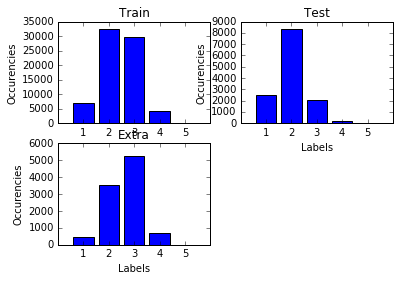

In [25]:
import matplotlib.pyplot as plt

plt.figure(1)

plt.subplot(221)
plt.bar(train_num_length.keys(), train_num_length.values(), align='center')
plt.xticks(train_num_length.keys())
plt.title('Train')
plt.xlabel('Labels')
plt.ylabel('Occurencies')

plt.subplot(222)
plt.bar(test_num_length.keys(), test_num_length.values(), align='center')
plt.xticks(test_num_length.keys())
plt.title('Test')
plt.xlabel('Labels')
plt.ylabel('Occurencies')

plt.subplot(223)
plt.bar(extra_num_length.keys(), extra_num_length.values(), align='center')
plt.xticks(test_num_length.keys())
plt.title('Extra')
plt.xlabel('Labels')
plt.ylabel('Occurencies')

plt.show()

In [26]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_labels = save['train_labels']
    test_labels = save['test_labels']
    valid_labels = save['valid_labels']
    del save

In [27]:
from collections import Counter

# Remove classes of empty labels
train_digits = Counter(train_labels.flatten()[np.where(train_labels.flatten() != 10)])
test_digits = Counter(test_labels.flatten()[np.where(test_labels.flatten() != 10)])
valid_digits = Counter(valid_labels.flatten()[np.where(valid_labels.flatten() != 10)])

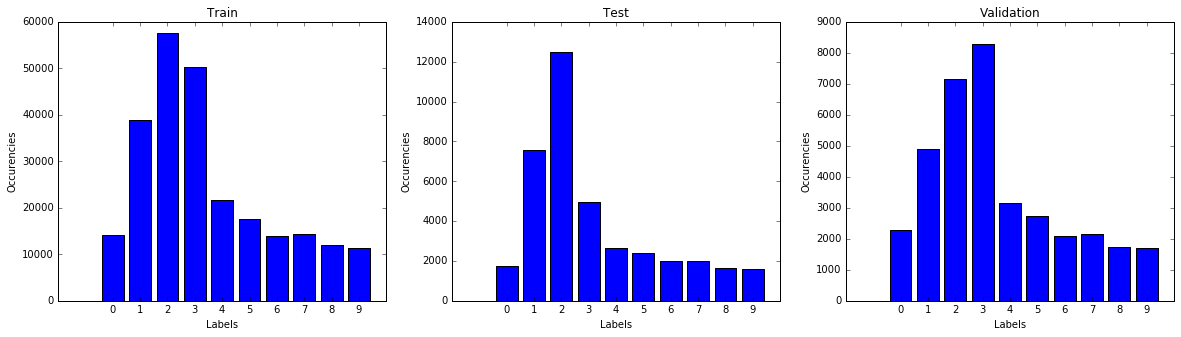

In [28]:

import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(train_digits.keys(), train_digits.values(), align='center')
ax1.set_xticks(train_digits.keys())
ax1.set_title('Train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Occurencies')

ax2.bar(test_digits.keys(), test_digits.values(), align='center')
ax2.set_xticks(test_digits.keys())
ax2.set_title('Test')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Occurencies')

ax3.bar(valid_digits.keys(), valid_digits.values(), align='center')
ax3.set_xticks(valid_digits.keys())
ax3.set_title('Validation')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Occurencies')

plt.show()